## Testing all available models to see which gives the best accuracy, speed and which models work in europe

This Jupyter Notebook systematically evaluates various Google Gemini models across specified Google Cloud Platform (GCP) regions. Its primary goal is to assess model availability and performance specifically for image analysis tasks relevant to this hackathon project.

The notebook iterates through a predefined list of Gemini models (e.g., `gemini-2.0-flash-001`, `gemini-1.5-pro-001`) and GCP regions (`us-central1`, `europe-west1`, etc.). For each image file found in the `inputs/` directory, it attempts an API call using a basic descriptive prompt to the designated model within the selected region.

Key metrics recorded include:
* API call success/failure status.
* Average processing time per image (in milliseconds) for successful calls.
* Any errors encountered during initialization or processing.

The results are presented in two ways:
1.  A **summary table** (using Pandas) for easy comparison of model availability and speed across different regions.
2.  A **bar chart** (using Matplotlib) visualizing the average processing times for available model/region combinations.

Additionally, the raw text outputs generated by successful model analyses are saved to `outputs/model_test_outputs.json`. This allows for manual review and qualitative assessment of the output precision and relevance for the project's specific needs.

This entire process facilitates the selection of the most suitable *accessible* model and region combination based on empirical performance data and manual quality evaluation.


### All the imports

In [75]:
# Cell 1: Imports and Setup (Explicit Path v4)
import os
import time
import logging
import json
from typing import List, Dict, Any
import sys
import traceback

# --- Project Path Setup ---
# Notebook is in the project root directory
project_root = os.path.abspath('.')
# Define the path to the src directory relative to the project root
src_path = os.path.join(project_root, 'src')

# --- Debugging Prints ---
print(f"DEBUG: Notebook directory (project root): {project_root}")
print(f"DEBUG: Calculated src path: {src_path}")
# ---

# Add src path to sys.path if not already present
if os.path.isdir(src_path): # Check if the calculated src_path actually exists
    if src_path not in sys.path:
        sys.path.insert(0, src_path)
        print(f"Added {src_path} to sys.path")
    else:
        print(f"{src_path} already in sys.path")
    print(f"DEBUG: Current sys.path includes: ...{sys.path[:3]}...") # Show first few paths
else:
    print(f"ERROR: Calculated src path does not exist: {src_path}")
    print("Please ensure the 'src' directory exists in the same folder as the notebook.")
    raise FileNotFoundError(f"src directory not found at expected location: {src_path}")


# Add src path to sys.path if not already present
if os.path.isdir(src_path): # Check if the calculated src_path actually exists
    if src_path not in sys.path:
        sys.path.insert(0, src_path)
        print(f"Added {src_path} to sys.path")
    else:
        print(f"{src_path} already in sys.path")
    print(f"DEBUG: Current sys.path includes: ...{sys.path[:3]}...") # Show first few paths
else:
    print(f"ERROR: Calculated src path does not exist: {src_path}")
    print("Please double-check the 'project_root' variable definition above.")
    raise FileNotFoundError(f"src directory not found at expected location: {src_path}")


# --- Library Imports ---
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import vertexai
    from vertexai.generative_models import GenerativeModel, Part, FinishReason, Image as VertexImage
    from google.api_core import exceptions as google_exceptions
    from IPython.display import display, Markdown
    print("Core libraries imported successfully.")
except ImportError as e:
    print(f"Error: Missing core libraries. Run 'pip install pandas matplotlib google-cloud-aiplatform ipython'. Details: {e}")
    raise

# --- Project Modules ---
try:
    import config
    print(f"Config loaded. Project ID: {config.GCP_PROJECT_ID}, Region: {config.GCP_REGION}")
    try:
        import utils
        print("Utils module loaded.")
    except ImportError:
        print("Utils module not found in src. Defining get_pdf_files_in_dir locally in Cell 2.")
        utils = None
except ImportError as e:
     print(f"Error loading config/utils from {src_path}: {e}")
     print("Please ensure the 'src' directory with config.py exists and paths are correct.")
     raise
except Exception as e:
    print(f"An unexpected error occurred loading config/utils: {e}")
    raise

# --- Logging Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger("google.api_core").setLevel(logging.WARNING)
logging.getLogger("google.auth").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("PIL").setLevel(logging.WARNING)

print("\nSetup cell execution complete.")

DEBUG: Notebook directory (project root): /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON
DEBUG: Calculated src path: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/src
/home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/src already in sys.path
DEBUG: Current sys.path includes: ...['/home/harishi/common_drive/Downloads/src', '/home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/src', '/home/harishi/miniconda3/envs/pytorch_env/lib/python310.zip']...
/home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/src already in sys.path
DEBUG: Current sys.path includes: ...['/home/harishi/common_drive/Downloads/src', '/home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/src', '/home/harishi/miniconda3/envs/pytorch_env/lib/python310.zip']...
Core libraries imported successfully.
Config loaded. Project ID: maximal-cider-458611-r5, Region: europe-west1
Utils module loaded.

Setup cell execution complete.


#### Okay after some testing I have come to realise europe-west2 and europe-west3 wont work for my region

### Configuration & Helper Functions

In [76]:
# Cell 2: Configuration & Helper Functions (UPDATED FOR JPEG TESTING)

# --- Test Configuration ---
REGIONS_TO_TEST = [
    "us-central1",    # Baseline
    "europe-west1",   # Belgium
    "europe-west4",   # Netherlands
]
# --- CHANGE 1: Define IMAGE extensions ---
IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"} # Add other image types if needed
# --- CHANGE 2: Update TEST_PROMPT for Images ---
TEST_PROMPT = "Describe this image briefly, focusing on any text present."
# --- CHANGE 3: Update Input Directory Path ---
INPUT_IMAGE_DIR_PATH = os.path.join(project_root, 'inputs', 'jpeg') # Specific JPEG input path
OUTPUT_DIR_PATH = os.path.join(project_root, 'outputs')
DETAILED_OUTPUT_FILENAME_BASE = "jpeg_model_test_outputs" # Base name for JSON output

# --- Debugging Print ---
print(f"DEBUG: Using Input Image Directory: {INPUT_IMAGE_DIR_PATH}")
# ---

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

# Store all results across different model tests for final graph
all_models_results_list = []
all_detailed_outputs = {}

# --- Helper Functions ---

# --- CHANGE 4: Revert to get_image_files_in_dir ---
def get_image_files_in_dir(image_input_dir: str) -> List[str]:
    """Gets a list of absolute paths for IMAGE files in the specified directory."""
    files = []
    abs_image_input_dir = os.path.abspath(image_input_dir)
    print(f"DEBUG: [get_image_files_in_dir] Checking for images in absolute path: {abs_image_input_dir}")

    if not os.path.isdir(abs_image_input_dir):
        logging.error(f"Image input directory not found or is not a directory: {abs_image_input_dir}")
        print(f"ERROR: [get_image_files_in_dir] Image input directory not found: {abs_image_input_dir}")
        return files

    logging.info(f"Scanning for image files in: {abs_image_input_dir}")
    found_count = 0
    try:
        for filename in os.listdir(abs_image_input_dir):
            if filename.startswith('.'): continue
            _, file_extension = os.path.splitext(filename.lower())
            if file_extension in IMAGE_EXTENSIONS: # Check against IMAGE_EXTENSIONS
                full_path = os.path.join(abs_image_input_dir, filename)
                if os.path.isfile(full_path):
                    files.append(os.path.abspath(full_path))
                    found_count += 1
                    logging.debug(f"Found image file: {full_path}")
    except Exception as e:
        logging.error(f"Error listing directory {abs_image_input_dir}: {e}")
        print(f"ERROR: [get_image_files_in_dir] Error listing directory {abs_image_input_dir}: {e}")
        return []

    logging.info(f"Found {found_count} image files in {abs_image_input_dir}.")
    print(f"DEBUG: [get_image_files_in_dir] Found {found_count} image files.")
    return files


# --- CHANGE 5: Revert test_model_in_region to handle IMAGES ---
def test_model_in_region(project_id: str, region: str, model_id: str, image_paths: List[str]) -> Dict[str, Any]:
    """Tests a single model in a specific region with multiple LOCAL IMAGES."""
    results = {
        "model": model_id,
        "region": region,
        "status": "Unknown",
        "avg_time_ms": None,
        "times_ms": [],
        "errors": [],
        "outputs": {}
    }
    model = None
    initialization_error = None

    logging.info(f"--- Testing: Initializing Vertex AI for {project_id} in {region} ---")
    try:
        vertexai.init(project=project_id, location=region)
        logging.info(f"Vertex AI Initialized for region {region}")
        logging.info(f"Instantiating model: {model_id}")
        model = GenerativeModel(model_id)
        logging.info(f"Model {model_id} instantiated.")
        results["status"] = "Initialized"
    # ... (keep identical exception handling for init as before) ...
    except google_exceptions.NotFound as e:
        logging.error(f"Initialization failed: Model {model_id} not found in {region}. Details: {e}")
        initialization_error = f"Model Not Found in {region}"
        results["status"] = "Model Not Found"
        results["errors"] = [initialization_error]
        return results
    except Exception as e:
        logging.error(f"Initialization failed for {model_id} in {region}: {e}", exc_info=True)
        initialization_error = f"Initialization Error: {type(e).__name__}"
        results["status"] = "Initialization Error"
        results["errors"] = [initialization_error]
        return results

    if not model:
         results["status"] = "Failed to Initialize (Unknown)"
         results["errors"] = ["Model object is None after initialization block."]
         return results

    start_time_total = time.time()
    for img_path in image_paths: # img_path is the absolute local path
        img_filename = os.path.basename(img_path)
        individual_start_time = time.time()
        try:
            # --- Load local IMAGE file using VertexImage ---
            logging.info(f"Processing LOCAL IMAGE: {img_filename}")
            try:
                # VertexImage handles loading and validation
                vertex_image = VertexImage.load_from_file(img_path)
            except FileNotFoundError:
                 logging.error(f"Local image file not found at path: {img_path}")
                 results["errors"].append(f"{img_filename}: Local file not found")
                 continue
            except Exception as load_err:
                 logging.error(f"Error loading local image file {img_path}: {load_err}")
                 results["errors"].append(f"{img_filename}: Local file load error")
                 continue

            # --- Create content list ---
            content = [vertex_image, TEST_PROMPT] # Use the image part and the image prompt

            # --- Generate Content (No request_options needed) ---
            response = model.generate_content(content, stream=False)

            # --- Response Handling (same as before) ---
            if not response.candidates or not hasattr(response.candidates[0], 'content') or not response.candidates[0].content or not response.candidates[0].content.parts:
                 logging.warning(f"Processing Error ({img_filename}): No content generated.")
                 results["errors"].append(f"{img_filename}: No Content")
                 continue
            try:
                generated_text = response.text
                individual_end_time = time.time()
                elapsed_ms = (individual_end_time - individual_start_time) * 1000
                results["times_ms"].append(elapsed_ms)
                results["outputs"][img_filename] = generated_text
            except Exception as inner_e:
                 logging.error(f"Error accessing response text for {img_filename}: {inner_e}")
                 results["errors"].append(f"{img_filename}: Response Processing Error")

        # --- API Error Handling (same as before) ---
        except google_exceptions.NotFound as e:
            error_msg = f"Model Not Found error during generate_content for {img_filename}: {e}"
            logging.error(error_msg)
            results["errors"].append(f"{img_filename}: Model Not Found Error")
            results["status"] = "Model Not Found"
            break
        except google_exceptions.ResourceExhausted as e:
            error_msg = f"Resource Exhausted error during generate_content for {img_filename}: {e}"
            logging.error(error_msg)
            results["errors"].append(f"{img_filename}: Resource Exhausted Error")
            results["status"] = "Resource Exhausted"
            break
        except google_exceptions.InvalidArgument as e:
            error_msg = f"Invalid Argument error for {img_filename}: {e}"
            logging.error(error_msg)
            results["errors"].append(f"{img_filename}: Invalid Argument Error")
        except Exception as e:
            error_msg = f"Generic processing error for {img_filename}: {e}"
            logging.error(error_msg, exc_info=True)
            results["errors"].append(f"{img_filename}: Processing Error ({type(e).__name__})")

    end_time_total = time.time()
    logging.info(f"Finished processing images for {model_id} in {region}. Total time: {end_time_total - start_time_total:.2f}s")

    # --- Final status determination (same as before) ---
    if results["status"] not in ["Model Not Found", "Resource Exhausted", "Initialization Error", "Failed to Initialize (Unknown)"]:
        if not results["times_ms"]:
             results["status"] = "Processing Errors"
        elif len(results["times_ms"]) < len(image_paths):
             results["status"] = "Partial Success"
             results["avg_time_ms"] = sum(results["times_ms"]) / len(results["times_ms"])
        else:
            results["status"] = "Available"
            results["avg_time_ms"] = sum(results["times_ms"]) / len(results["times_ms"])
    if results["status"] not in ["Available", "Partial Success"]:
         results["avg_time_ms"] = None

    return results

print("Helper functions defined/updated for LOCAL IMAGE testing.")

DEBUG: Using Input Image Directory: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/jpeg
Helper functions defined/updated for LOCAL IMAGE testing.


### Get Image Files

In [77]:
# Cell 3: Get Image Files (UPDATED)

# Use the IMAGE helper function and the specific IMAGE input path
image_files_to_test = get_image_files_in_dir(INPUT_IMAGE_DIR_PATH) # Changed function name and path variable

if not image_files_to_test:
    raise FileNotFoundError(f"No image files found in {INPUT_IMAGE_DIR_PATH}. Please add image files to the '../inputs/jpeg' directory.")
else:
    print(f"Found {len(image_files_to_test)} image files for testing in {INPUT_IMAGE_DIR_PATH}.")
    # print("First 5 files:", image_files_to_test[:5]) # Optional: print first few files

2025-05-03 12:42:08,247 - INFO - Scanning for image files in: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/jpeg
2025-05-03 12:42:08,248 - INFO - Found 5 image files in /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/jpeg.


DEBUG: [get_image_files_in_dir] Checking for images in absolute path: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/jpeg
DEBUG: [get_image_files_in_dir] Found 5 image files.
Found 5 image files for testing in /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/jpeg.


### Test gemini-2.0-flash-001

In [78]:
# Cell 4: Test gemini-2.0-flash-001 (Corrected Argument and Keys)
model_id_to_test = "gemini-2.0-flash-001"
print(f"\n===== Testing Model: {model_id_to_test} =====")
model_results = []
model_outputs = {}

for region in REGIONS_TO_TEST:
    # Use the corrected argument name 'pdf_paths'
    result_data = test_model_in_region(
        project_id=config.GCP_PROJECT_ID,
        region=region,
        model_id=model_id_to_test,
        image_paths=image_files_to_test # Correct argument name
    )
    model_results.append(result_data)
    all_models_results_list.append(result_data) # Add to the global list for final graph
    if result_data["status"] in ["Available", "Partial Success"] and result_data["outputs"]:
        key = f"{region}_{model_id_to_test}"
        model_outputs[key] = result_data["outputs"]
        all_detailed_outputs[key] = result_data["outputs"] # Add to global dict
    time.sleep(1) # Small delay between regions

# Display results for this model
summary_df = pd.DataFrame(model_results)
# Use the CORRECT key 'avg_time_ms'
summary_df['avg_time_ms'] = pd.to_numeric(summary_df['avg_time_ms'], errors='coerce').apply(
    lambda x: f"{x:.0f}" if pd.notnull(x) else "N/A"
)
# Simplify error display for the table
summary_df['Errors'] = summary_df['errors'].apply(
    lambda err_list: "None" if not err_list else f"{len(err_list)} errors (see logs/JSON)"
)
print(f"\n--- Test Summary for {model_id_to_test} ---")
# --- Use the CORRECT keys 'region', 'status', 'avg_time_ms' ---
display(summary_df[['region', 'status', 'avg_time_ms', 'Errors']])
# --- END CORRECTION ---


# Save detailed output for this model specifically if needed
# output_json_path_model = os.path.join(OUTPUT_DIR_PATH, f"{DETAILED_OUTPUT_FILENAME_BASE}_{model_id_to_test}.json")
# try:
#     with open(output_json_path_model, 'w', encoding='utf-8') as f:
#         json.dump(model_outputs, f, indent=4, ensure_ascii=False)
#     logging.info(f"Detailed outputs for {model_id_to_test} saved to {output_json_path_model}")
# except Exception as e:
#     logging.error(f"Failed to save detailed outputs for {model_id_to_test}: {e}")

2025-05-03 12:42:08,255 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in us-central1 ---
2025-05-03 12:42:08,255 - INFO - Vertex AI Initialized for region us-central1
2025-05-03 12:42:08,256 - INFO - Instantiating model: gemini-2.0-flash-001
2025-05-03 12:42:08,256 - INFO - Model gemini-2.0-flash-001 instantiated.
2025-05-03 12:42:08,256 - INFO - Processing LOCAL IMAGE: 1.jpeg



===== Testing Model: gemini-2.0-flash-001 =====


2025-05-03 12:42:11,338 - INFO - Processing LOCAL IMAGE: 2.jpeg
2025-05-03 12:42:14,134 - INFO - Processing LOCAL IMAGE: 3.jpeg
2025-05-03 12:42:16,892 - INFO - Processing LOCAL IMAGE: 4.jpeg
2025-05-03 12:42:19,350 - INFO - Processing LOCAL IMAGE: 5.jpeg
2025-05-03 12:42:22,627 - INFO - Finished processing images for gemini-2.0-flash-001 in us-central1. Total time: 14.37s
2025-05-03 12:42:23,630 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in europe-west1 ---
2025-05-03 12:42:23,631 - INFO - Vertex AI Initialized for region europe-west1
2025-05-03 12:42:23,632 - INFO - Instantiating model: gemini-2.0-flash-001
2025-05-03 12:42:23,633 - INFO - Model gemini-2.0-flash-001 instantiated.
2025-05-03 12:42:23,634 - INFO - Processing LOCAL IMAGE: 1.jpeg
2025-05-03 12:42:26,526 - INFO - Processing LOCAL IMAGE: 2.jpeg
2025-05-03 12:42:28,669 - INFO - Processing LOCAL IMAGE: 3.jpeg
2025-05-03 12:42:30,819 - INFO - Processing LOCAL IMAGE: 4.jpeg
2025-05-03 12:42:32,969


--- Test Summary for gemini-2.0-flash-001 ---


,region,status,avg_time_ms,Errors
0,us-central1,Available,2874,None
1,europe-west1,Available,2399,None
2,europe-west4,Available,2093,None


### Test gemini-2.0-flash-lite-001

In [79]:
# Cell 5: Test gemini-2.0-flash-lite-001 (Corrected Argument and Keys)
model_id_to_test = "gemini-2.0-flash-lite-001"
print(f"\n===== Testing Model: {model_id_to_test} =====")
model_results = []
model_outputs = {}

for region in REGIONS_TO_TEST:
    # --- Use the corrected argument name 'pdf_paths' ---
    result_data = test_model_in_region(
        project_id=config.GCP_PROJECT_ID,
        region=region,
        model_id=model_id_to_test,
        image_paths=image_files_to_test # <<< Corrected argument name here
    )
    # --- END CORRECTION ---
    model_results.append(result_data)
    all_models_results_list.append(result_data) # Add to the global list
    if result_data["status"] in ["Available", "Partial Success"] and result_data["outputs"]:
        key = f"{region}_{model_id_to_test}"
        model_outputs[key] = result_data["outputs"]
        all_detailed_outputs[key] = result_data["outputs"] # Add to global dict
    time.sleep(1)

# Display results for this model
summary_df = pd.DataFrame(model_results)
# --- Use the CORRECT key 'avg_time_ms' ---
summary_df['avg_time_ms'] = pd.to_numeric(summary_df['avg_time_ms'], errors='coerce').apply(
    lambda x: f"{x:.0f}" if pd.notnull(x) else "N/A"
)
# --- END CORRECTION ---
summary_df['Errors'] = summary_df['errors'].apply(
    lambda err_list: "None" if not err_list else f"{len(err_list)} errors (see logs/JSON)"
)
print(f"\n--- Test Summary for {model_id_to_test} ---")
# --- Use the CORRECT keys 'region', 'status', 'avg_time_ms' ---
display(summary_df[['region', 'status', 'avg_time_ms', 'Errors']])
# --- END CORRECTION ---

2025-05-03 12:42:48,122 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in us-central1 ---
2025-05-03 12:42:48,123 - INFO - Vertex AI Initialized for region us-central1
2025-05-03 12:42:48,124 - INFO - Instantiating model: gemini-2.0-flash-lite-001
2025-05-03 12:42:48,125 - INFO - Model gemini-2.0-flash-lite-001 instantiated.
2025-05-03 12:42:48,125 - INFO - Processing LOCAL IMAGE: 1.jpeg



===== Testing Model: gemini-2.0-flash-lite-001 =====


2025-05-03 12:42:50,756 - INFO - Processing LOCAL IMAGE: 2.jpeg
2025-05-03 12:42:53,226 - INFO - Processing LOCAL IMAGE: 3.jpeg
2025-05-03 12:42:56,009 - INFO - Processing LOCAL IMAGE: 4.jpeg
2025-05-03 12:42:58,876 - INFO - Processing LOCAL IMAGE: 5.jpeg
2025-05-03 12:43:00,967 - INFO - Finished processing images for gemini-2.0-flash-lite-001 in us-central1. Total time: 12.84s
2025-05-03 12:43:01,969 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in europe-west1 ---
2025-05-03 12:43:01,970 - INFO - Vertex AI Initialized for region europe-west1
2025-05-03 12:43:01,970 - INFO - Instantiating model: gemini-2.0-flash-lite-001
2025-05-03 12:43:01,970 - INFO - Model gemini-2.0-flash-lite-001 instantiated.
2025-05-03 12:43:01,971 - INFO - Processing LOCAL IMAGE: 1.jpeg
2025-05-03 12:43:03,690 - INFO - Processing LOCAL IMAGE: 2.jpeg
2025-05-03 12:43:06,250 - INFO - Processing LOCAL IMAGE: 3.jpeg
2025-05-03 12:43:07,990 - INFO - Processing LOCAL IMAGE: 4.jpeg
2025-05-


--- Test Summary for gemini-2.0-flash-lite-001 ---


,region,status,avg_time_ms,Errors
0,us-central1,Available,2568,None
1,europe-west1,Available,1900,None
2,europe-west4,Available,1753,None


### Test gemini-1.5-pro-001

In [80]:
# Cell 6: Test gemini-1.5-pro-001 (Corrected Argument and Keys)
model_id_to_test = "gemini-1.5-pro-001"
print(f"\n===== Testing Model: {model_id_to_test} =====")
model_results = []
model_outputs = {}

for region in REGIONS_TO_TEST:
    # --- Use the corrected argument name 'pdf_paths' ---
    result_data = test_model_in_region(
        project_id=config.GCP_PROJECT_ID,
        region=region,
        model_id=model_id_to_test,
        image_paths=image_files_to_test # <<< Corrected argument name here
    )
    # --- END CORRECTION ---
    model_results.append(result_data)
    all_models_results_list.append(result_data) # Add to the global list
    if result_data["status"] in ["Available", "Partial Success"] and result_data["outputs"]:
        key = f"{region}_{model_id_to_test}"
        model_outputs[key] = result_data["outputs"]
        all_detailed_outputs[key] = result_data["outputs"] # Add to global dict
    time.sleep(1)

# Display results for this model
summary_df = pd.DataFrame(model_results)
# --- Use the CORRECT key 'avg_time_ms' ---
summary_df['avg_time_ms'] = pd.to_numeric(summary_df['avg_time_ms'], errors='coerce').apply(
    lambda x: f"{x:.0f}" if pd.notnull(x) else "N/A"
)
# --- END CORRECTION ---
summary_df['Errors'] = summary_df['errors'].apply(
    lambda err_list: "None" if not err_list else f"{len(err_list)} errors (see logs/JSON)"
)
print(f"\n--- Test Summary for {model_id_to_test} ---")
# --- Use the CORRECT keys 'region', 'status', 'avg_time_ms' ---
display(summary_df[['region', 'status', 'avg_time_ms', 'Errors']])
# --- END CORRECTION ---

2025-05-03 12:43:22,269 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in us-central1 ---
2025-05-03 12:43:22,270 - INFO - Vertex AI Initialized for region us-central1
2025-05-03 12:43:22,270 - INFO - Instantiating model: gemini-1.5-pro-001
2025-05-03 12:43:22,271 - INFO - Model gemini-1.5-pro-001 instantiated.
2025-05-03 12:43:22,271 - INFO - Processing LOCAL IMAGE: 1.jpeg



===== Testing Model: gemini-1.5-pro-001 =====


2025-05-03 12:43:23,554 - ERROR - Model Not Found error during generate_content for 1.jpeg: 404 Publisher Model `projects/maximal-cider-458611-r5/locations/us-central1/publishers/google/models/gemini-1.5-pro-001` was not found or your project does not have access to it. Please ensure you are using a valid model version. For more information, see: https://cloud.google.com/vertex-ai/generative-ai/docs/learn/model-versions
2025-05-03 12:43:23,555 - INFO - Finished processing images for gemini-1.5-pro-001 in us-central1. Total time: 1.28s
2025-05-03 12:43:24,557 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in europe-west1 ---
2025-05-03 12:43:24,558 - INFO - Vertex AI Initialized for region europe-west1
2025-05-03 12:43:24,558 - INFO - Instantiating model: gemini-1.5-pro-001
2025-05-03 12:43:24,558 - INFO - Model gemini-1.5-pro-001 instantiated.
2025-05-03 12:43:24,559 - INFO - Processing LOCAL IMAGE: 1.jpeg
2025-05-03 12:43:24,777 - ERROR - Model Not Found erro


--- Test Summary for gemini-1.5-pro-001 ---


,region,status,avg_time_ms,Errors
0,us-central1,Model Not Found,N/A,1 errors (see logs/JSON)
1,europe-west1,Model Not Found,N/A,1 errors (see logs/JSON)
2,europe-west4,Model Not Found,N/A,1 errors (see logs/JSON)


### Test gemini-2.5-pro-preview-03-25

In [81]:
# Cell 7: Test gemini-2.5-pro-preview-03-25 (Corrected Argument and Keys)
model_id_to_test = "gemini-2.5-pro-preview-03-25" # Use the specific preview identifier
print(f"\n===== Testing Model: {model_id_to_test} =====")
print("NOTE: Preview models may have limited regional availability and different behavior.")
model_results = []
model_outputs = {}

for region in REGIONS_TO_TEST:
    # --- Use the corrected argument name 'pdf_paths' ---
    result_data = test_model_in_region(
        project_id=config.GCP_PROJECT_ID,
        region=region,
        model_id=model_id_to_test,
        image_paths=image_files_to_test # <<< Corrected argument name here
    )
    # --- END CORRECTION ---
    model_results.append(result_data)
    all_models_results_list.append(result_data) # Add to the global list
    if result_data["status"] in ["Available", "Partial Success"] and result_data["outputs"]:
        key = f"{region}_{model_id_to_test}"
        model_outputs[key] = result_data["outputs"]
        all_detailed_outputs[key] = result_data["outputs"] # Add to global dict
    time.sleep(1)

# Display results for this model
summary_df = pd.DataFrame(model_results)
# --- Use the CORRECT key 'avg_time_ms' ---
summary_df['avg_time_ms'] = pd.to_numeric(summary_df['avg_time_ms'], errors='coerce').apply(
    lambda x: f"{x:.0f}" if pd.notnull(x) else "N/A"
)
# --- END CORRECTION ---
summary_df['Errors'] = summary_df['errors'].apply(
    lambda err_list: "None" if not err_list else f"{len(err_list)} errors (see logs/JSON)"
)
print(f"\n--- Test Summary for {model_id_to_test} ---")
# --- Use the CORRECT keys 'region', 'status', 'avg_time_ms' ---
display(summary_df[['region', 'status', 'avg_time_ms', 'Errors']])
# --- END CORRECTION ---

2025-05-03 12:43:26,999 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in us-central1 ---
2025-05-03 12:43:27,000 - INFO - Vertex AI Initialized for region us-central1
2025-05-03 12:43:27,001 - INFO - Instantiating model: gemini-2.5-pro-preview-03-25
2025-05-03 12:43:27,001 - INFO - Model gemini-2.5-pro-preview-03-25 instantiated.
2025-05-03 12:43:27,002 - INFO - Processing LOCAL IMAGE: 1.jpeg



===== Testing Model: gemini-2.5-pro-preview-03-25 =====
NOTE: Preview models may have limited regional availability and different behavior.


2025-05-03 12:43:44,241 - INFO - Processing LOCAL IMAGE: 2.jpeg
2025-05-03 12:44:01,808 - INFO - Processing LOCAL IMAGE: 3.jpeg
2025-05-03 12:44:19,775 - INFO - Processing LOCAL IMAGE: 4.jpeg
2025-05-03 12:44:38,205 - INFO - Processing LOCAL IMAGE: 5.jpeg
2025-05-03 12:44:56,433 - INFO - Finished processing images for gemini-2.5-pro-preview-03-25 in us-central1. Total time: 89.43s
2025-05-03 12:44:57,435 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in europe-west1 ---
2025-05-03 12:44:57,436 - INFO - Vertex AI Initialized for region europe-west1
2025-05-03 12:44:57,437 - INFO - Instantiating model: gemini-2.5-pro-preview-03-25
2025-05-03 12:44:57,438 - INFO - Model gemini-2.5-pro-preview-03-25 instantiated.
2025-05-03 12:44:57,439 - INFO - Processing LOCAL IMAGE: 1.jpeg
2025-05-03 12:44:57,666 - ERROR - Model Not Found error during generate_content for 1.jpeg: 404 Publisher Model `projects/maximal-cider-458611-r5/locations/europe-west1/publishers/google/mode


--- Test Summary for gemini-2.5-pro-preview-03-25 ---


,region,status,avg_time_ms,Errors
0,us-central1,Available,17886,None
1,europe-west1,Model Not Found,N/A,1 errors (see logs/JSON)
2,europe-west4,Model Not Found,N/A,1 errors (see logs/JSON)


In [85]:
# Cell 8: Test gemini-2.5-pro-preview-03-25 (Corrected Argument and Keys)
model_id_to_test = "gemini-2.5-flash-preview-04-17" # Use the specific preview identifier
print(f"\n===== Testing Model: {model_id_to_test} =====")
print("NOTE: Preview models may have limited regional availability and different behavior.")
model_results = []
model_outputs = {}

for region in REGIONS_TO_TEST:
    # --- Use the corrected argument name 'pdf_paths' ---
    result_data = test_model_in_region(
        project_id=config.GCP_PROJECT_ID,
        region=region,
        model_id=model_id_to_test,
        image_paths=image_files_to_test # <<< Corrected argument name here
    )
    # --- END CORRECTION ---
    model_results.append(result_data)
    all_models_results_list.append(result_data) # Add to the global list
    if result_data["status"] in ["Available", "Partial Success"] and result_data["outputs"]:
        key = f"{region}_{model_id_to_test}"
        model_outputs[key] = result_data["outputs"]
        all_detailed_outputs[key] = result_data["outputs"] # Add to global dict
    time.sleep(1)

# Display results for this model
summary_df = pd.DataFrame(model_results)
# --- Use the CORRECT key 'avg_time_ms' ---
summary_df['avg_time_ms'] = pd.to_numeric(summary_df['avg_time_ms'], errors='coerce').apply(
    lambda x: f"{x:.0f}" if pd.notnull(x) else "N/A"
)
# --- END CORRECTION ---
summary_df['Errors'] = summary_df['errors'].apply(
    lambda err_list: "None" if not err_list else f"{len(err_list)} errors (see logs/JSON)"
)
print(f"\n--- Test Summary for {model_id_to_test} ---")
# --- Use the CORRECT keys 'region', 'status', 'avg_time_ms' ---
display(summary_df[['region', 'status', 'avg_time_ms', 'Errors']])
# --- END CORRECTION ---

2025-05-03 12:52:46,795 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in us-central1 ---
2025-05-03 12:52:46,797 - INFO - Vertex AI Initialized for region us-central1
2025-05-03 12:52:46,797 - INFO - Instantiating model: gemini-2.5-flash-preview-04-17
2025-05-03 12:52:46,798 - INFO - Model gemini-2.5-flash-preview-04-17 instantiated.
2025-05-03 12:52:46,798 - INFO - Processing LOCAL IMAGE: 1.jpeg



===== Testing Model: gemini-2.5-flash-preview-04-17 =====
NOTE: Preview models may have limited regional availability and different behavior.


2025-05-03 12:52:59,256 - INFO - Processing LOCAL IMAGE: 2.jpeg
2025-05-03 12:53:04,067 - INFO - Processing LOCAL IMAGE: 3.jpeg
2025-05-03 12:53:09,400 - INFO - Processing LOCAL IMAGE: 4.jpeg
2025-05-03 12:53:13,385 - INFO - Processing LOCAL IMAGE: 5.jpeg
2025-05-03 12:53:23,830 - INFO - Finished processing images for gemini-2.5-flash-preview-04-17 in us-central1. Total time: 37.03s
2025-05-03 12:53:24,832 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in europe-west1 ---
2025-05-03 12:53:24,834 - INFO - Vertex AI Initialized for region europe-west1
2025-05-03 12:53:24,835 - INFO - Instantiating model: gemini-2.5-flash-preview-04-17
2025-05-03 12:53:24,836 - INFO - Model gemini-2.5-flash-preview-04-17 instantiated.
2025-05-03 12:53:24,838 - INFO - Processing LOCAL IMAGE: 1.jpeg
2025-05-03 12:53:25,071 - ERROR - Model Not Found error during generate_content for 1.jpeg: 404 Publisher Model `projects/maximal-cider-458611-r5/locations/europe-west1/publishers/googl


--- Test Summary for gemini-2.5-flash-preview-04-17 ---


,region,status,avg_time_ms,Errors
0,us-central1,Available,7406,None
1,europe-west1,Model Not Found,N/A,1 errors (see logs/JSON)
2,europe-west4,Model Not Found,N/A,1 errors (see logs/JSON)


### Save Combined Detailed Outputs

In [86]:
# Cell 9: Save Combined Detailed Outputs
# Save all collected detailed outputs to a single JSON file
output_json_path_combined = os.path.join(OUTPUT_DIR_PATH, f"{DETAILED_OUTPUT_FILENAME_BASE}_all.json")
try:
    with open(output_json_path_combined, 'w', encoding='utf-8') as f:
        json.dump(all_detailed_outputs, f, indent=4, ensure_ascii=False)
    logging.info(f"Combined detailed outputs saved to {output_json_path_combined}")
except Exception as e:
    logging.error(f"Failed to save combined detailed outputs: {e}")

2025-05-03 12:54:01,796 - INFO - Combined detailed outputs saved to /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/outputs/jpeg_model_test_outputs_all.json


### Combined Graph Rendering

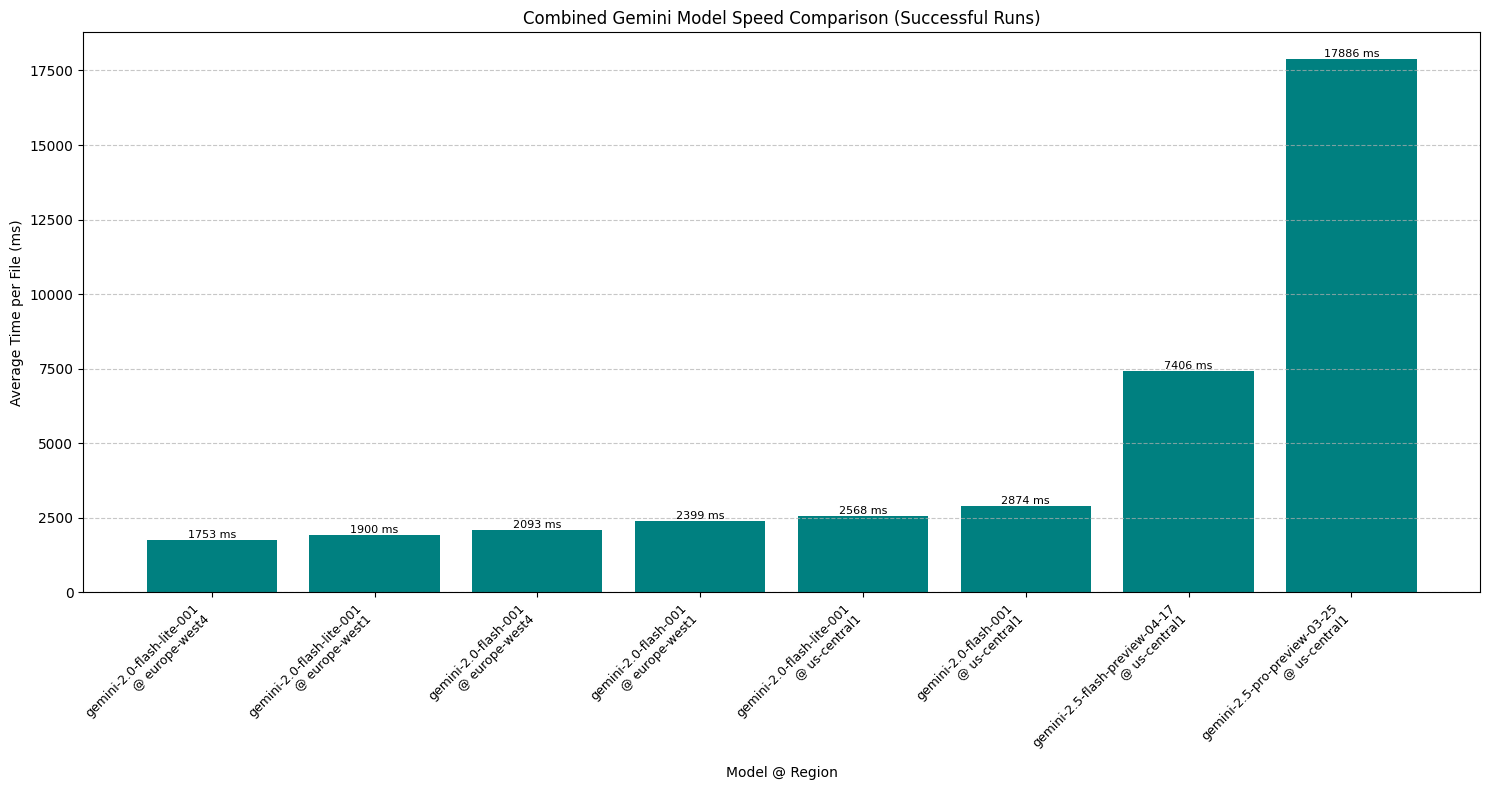

In [87]:
# Cell 10: Combined Graph Rendering (Corrected Keys)
# Ensure matplotlib.pyplot (plt) and pandas (pd) are imported from Cell 1

# Create DataFrame from the combined results collected across all model tests
combined_summary_df = pd.DataFrame(all_models_results_list)

# --- Use CORRECT lowercase keys for filtering ---
available_df = combined_summary_df[
    (combined_summary_df['status'].isin(['Available', 'Partial Success'])) & pd.notnull(combined_summary_df['avg_time_ms'])
].copy() # Use copy to avoid SettingWithCopyWarning
# --- END CORRECTION ---

if not available_df.empty:
    # --- Use CORRECT lowercase key for numeric conversion ---
    # Convert 'avg_time_ms' back to numeric for sorting/plotting
    available_df['avg_time_ms'] = pd.to_numeric(available_df['avg_time_ms'], errors='coerce')
    # --- END CORRECTION ---

    # --- Use CORRECT lowercase keys for label creation ---
    # Create a combined label for the x-axis
    available_df['Label'] = available_df['model'] + '\n@ ' + available_df['region']
     # --- END CORRECTION ---
    # Sort by average time for better visualization
    available_df.sort_values('avg_time_ms', inplace=True)

    plt.figure(figsize=(15, 8)) # Adjust figure size if needed
    # --- Use CORRECT lowercase key for plotting ---
    bars = plt.bar(available_df['Label'], available_df['avg_time_ms'], color='teal') # Changed color
    # --- END CORRECTION ---

    plt.xlabel("Model @ Region")
    plt.ylabel("Average Time per File (ms)") # Updated label
    plt.title("Combined Gemini Model Speed Comparison (Successful Runs)") # Updated title
    plt.xticks(rotation=45, ha='right', fontsize=9) # Rotate labels for readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust layout to prevent labels overlapping

    # Add text labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.0f} ms', va='bottom', ha='center', fontsize=8)

    plt.show() # Display the plot in the notebook
else:
    print("No data with successful runs available across all models for combined graph generation.")

### Final Verdict

Based on the results from the model testing across different regions:

* **Models Tested:** We evaluated `gemini-2.0-flash-001`, `gemini-2.0-flash-lite-001`, `gemini-1.5-pro-001`, `gemini-2.5-pro-preview-03-25`, and `gemini-2.5-flash-preview-04-17`.
* **Availability:** The summary tables show that `gemini-2.0-flash-001` and `gemini-2.0-flash-lite-001` were consistently available across the tested regions (`us-central1`, `europe-west1`, `europe-west4`). In contrast, the Pro models (`1.5-pro-001`, `2.5-pro-preview-03-25`) and the `2.5-flash-preview-04-17` were **not found** in the target European regions (`europe-west1`, `europe-west4`), only showing results for `us-central1`. This makes the 2.0 Flash models the only viable options for deployment in the desired European locations.
* **Speed:** The combined graph clearly illustrates the speed differences.
    * `gemini-2.0-flash-lite-001` is the fastest overall, particularly in `europe-west4` (averaging ~1753 ms per file).
    * `gemini-2.0-flash-001` is slightly slower but still performs well in European regions (~2093 ms in `europe-west4`).
    * The preview models (`2.5-flash-preview` and `2.5-pro-preview`) were significantly slower where available (e.g., ~7406 ms and ~17886 ms respectively in `us-central1`).
* **Accuracy vs. Speed Trade-off:** While newer Pro models might offer higher base accuracy, their lack of availability in the target regions and significantly slower speed (where available) make them impractical for this project's goal of a responsive EdTech tool deployed in Europe.
* **Fine-Tuning Strategy:** The primary strategy for achieving high accuracy and reliable localization for the specific document analysis task is through **fine-tuning**. The fine-tuning job was initiated using a `gemini-2.0-flash-lite-001` base. This process is designed to specialize the faster Flash-Lite model for the required accuracy.

**Conclusion:**

Considering the critical factors of **regional availability** (essential for deployment in `europe-west4` or `europe-west1`) and **inference speed** (important for user experience), combined with the strategy of using **fine-tuning** to achieve task-specific accuracy, the **`gemini-2.0-flash-lite-001` model is the best choice** for this project. We will proceed using the fine-tuned version of this model once the tuning job completes successfully.

*For qualitative comparison of the outputs from the models that *were* available, refer to the detailed JSON file saved in the `outputs/` directory.*